# SAUCIE 1.3M 10x Demonstration

In [4]:
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotting
import scipy.sparse as sp_sparse
import tables
import tensorflow as tf
import saucie_utils as utils
import scipy
import saucie
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from saucie_utils import DataSet
from sklearn.manifold import TSNE
from saucie import Saucie
from run import train

np.random.seed(utils.RAND_SEED)
tf.set_random_seed(utils.RAND_SEED)

KeyboardInterrupt: 

## Loading and Exploration

In [75]:
GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names.astype(str) == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

In [76]:
filtered_matrix_h5 = "/data/krishnan/mouse_data/1M_neurons_neuron20k.h5"
genome = "mm10"
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)
gene_bc_matrix.matrix.shape # shape of matrix is genes x cells

CPU times: user 1.4 s, sys: 186 ms, total: 1.59 s
Wall time: 1.71 s


(27998, 20000)

In [81]:
# # library size normalization
x = gene_bc_matrix.matrix.asfptype().transpose()
gene_sum = x.sum(axis=1)
x = x / gene_sum * np.median(gene_sum.tolist())
x = np.sqrt(x)
pca = PCA(40)
x_reduced = pca.fit_transform(x)

In [82]:
ms = MinMaxScaler()
x_red_scaled = ms.fit_transform(x_reduced)
train_data, test_data = train_test_split(x_red_scaled, train_size=0.9, random_state=utils.RAND_SEED)
data_dict = dict(_data=train_data, _test_data=test_data, _min=ms.data_min_, _max=ms.data_max_,
                 _mean_offset=pca.mean_, _genes=gene_bc_matrix.gene_names.astype(str).tolist(), _components=pca.components_, labeled=False)
data = DataSet(**data_dict)
data.save('/data/krishnan/mouse_data/20k_subset_pca.npz')

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [84]:
def data_inverse(data, x=None):
    if x is None:
        x = np.concatenate([data.data, data.test_data])
    x = np.dot(x, data._components) + data._mean_offset
    return x

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


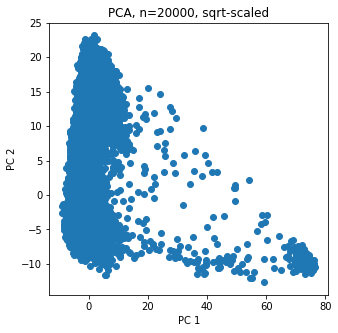

In [6]:
f, ac = plt.subplots(figsize=(5,5))
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, n={}, sqrt-scaled'.format(x_reduced.shape[0]))

### Plotting UMI and genes per cell

In [37]:
umis_per_cell = np.asarray(gene_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((gene_bc_matrix.matrix > 0).sum(axis=0)).squeeze()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


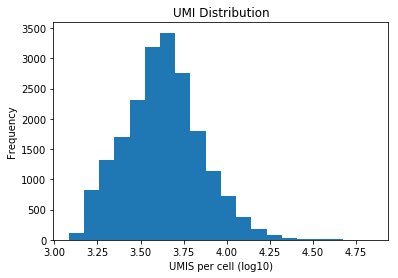

In [38]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


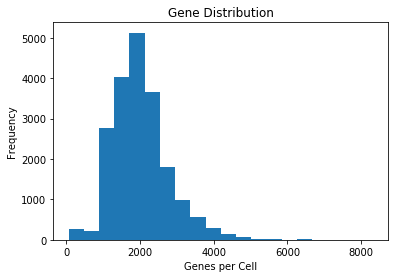

In [39]:
# plot genes per cell
plt.hist(genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

## SAUCIE analysis

In [26]:
data = DataSet.load('/data/krishnan/mouse_data/20k_subset_pca.npz')

In [95]:
config = saucie.default_config()
config['act_fn'] = 'tanh'
config['d_act_fn'] = 'tanh'
config['encoder_layers'] = [1024,512,256]
config['emb_dim'] = 10
config['id_norm'] = 'tanh'
config['input_dim'] = data.data.shape[1]
id_lam = 1e-3
config['sparse_config'] = utils.SparseLayerConfig(id_lam=np.array([0,0,id_lam], dtype=utils.FLOAT_DTYPE))
config['save_path'] = './saucie_models/mouse'
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 40)
('encoder_layers', [1024, 512, 256])
('emb_dim', 10)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0010000000474974513],l1_lam=[0.0, 0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0, 0.0]))
('save_path', './saucie_models/mouse')


In [ ]:
utils.load_dataset_from_mat('/data/krishnan/emt_r'

In [3]:
# TRAINING FLAGS
batch_size = 200     # size of batch during training
num_epochs = 60      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 50       # training loss logging frequency
save_every = 150     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

steps_per_epoch = data.num_samples // batch_size
num_steps = steps_per_epoch * num_epochs
print('steps per epoch: {}, num steps: {}'.format(steps_per_epoch, num_steps))

NameError: name 'data' is not defined

In [1]:
sess.close()
tf.reset_default_graph()

NameError: name 'sess' is not defined

In [2]:
if verbose:
    tf.logging.set_verbosity(tf.logging.DEBUG)
else:
    tf.logging.set_verbosity(tf.logging.INFO)

model = Saucie(**config)
plot_dir = model.save_path + '/plots'
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_mem)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
model.build(sess)

NameError: name 'verbose' is not defined

In [98]:
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots, train_id=True)

Saving all run data to: ./saucie_models/mouse/17-10-12-runs/4
INFO:tensorflow:Total steps: 5400
INFO:tensorflow:TESTING -- epoch: 1, loss: 0.693647, recons_loss: 0.693307, id_loss: 0.000339437
INFO:tensorflow:Best model saved after 1 epochs
INFO:tensorflow:epoch 1, step 39/5400: loss: 0.665326, recons_loss: 0.665178, id_loss: 0.000148637
INFO:tensorflow:epoch 1, step 89/5400: loss: 0.665353, recons_loss: 0.665206, id_loss: 0.000147336
INFO:tensorflow:TESTING -- epoch: 2, loss: 0.669095, recons_loss: 0.668794, id_loss: 0.000301211
INFO:tensorflow:Best model saved after 2 epochs
INFO:tensorflow:epoch 2, step 139/5400: loss: 0.664273, recons_loss: 0.664127, id_loss: 0.000145641
INFO:tensorflow:Saving model, after step 150
INFO:tensorflow:TESTING -- epoch: 3, loss: 0.665754, recons_loss: 0.665499, id_loss: 0.000255293
INFO:tensorflow:Best model saved after 3 epochs
INFO:tensorflow:epoch 3, step 189/5400: loss: 0.663638, recons_loss: 0.663492, id_loss: 0.000145876
INFO:tensorflow:epoch 3, s

INFO:tensorflow:epoch 24, step 2089/5400: loss: 0.656336, recons_loss: 0.656248, id_loss: 8.85603E-05
INFO:tensorflow:Saving model, after step 2100
INFO:tensorflow:epoch 24, step 2139/5400: loss: 0.656794, recons_loss: 0.656706, id_loss: 8.80567E-05
INFO:tensorflow:TESTING -- epoch: 25, loss: 0.656088, recons_loss: 0.656001, id_loss: 8.75545E-05
INFO:tensorflow:Best model saved after 25 epochs
INFO:tensorflow:epoch 25, step 2189/5400: loss: 0.6552, recons_loss: 0.65511, id_loss: 9.03100E-05
INFO:tensorflow:epoch 25, step 2239/5400: loss: 0.657115, recons_loss: 0.657028, id_loss: 8.68166E-05
INFO:tensorflow:Saving model, after step 2250
INFO:tensorflow:TESTING -- epoch: 26, loss: 0.656061, recons_loss: 0.655974, id_loss: 8.69529E-05
INFO:tensorflow:Best model saved after 26 epochs
INFO:tensorflow:epoch 26, step 2289/5400: loss: 0.656021, recons_loss: 0.655933, id_loss: 8.79577E-05
INFO:tensorflow:epoch 26, step 2339/5400: loss: 0.655361, recons_loss: 0.655274, id_loss: 8.77826E-05
INFO:

INFO:tensorflow:epoch 48, step 4289/5400: loss: 0.654813, recons_loss: 0.654731, id_loss: 8.19435E-05
INFO:tensorflow:TESTING -- epoch: 49, loss: 0.655167, recons_loss: 0.655085, id_loss: 8.13304E-05
INFO:tensorflow:epoch 49, step 4339/5400: loss: 0.654178, recons_loss: 0.654096, id_loss: 8.14610E-05
INFO:tensorflow:Saving model, after step 4350
INFO:tensorflow:epoch 49, step 4389/5400: loss: 0.655572, recons_loss: 0.655491, id_loss: 8.10267E-05
INFO:tensorflow:TESTING -- epoch: 50, loss: 0.654974, recons_loss: 0.654892, id_loss: 8.13689E-05
INFO:tensorflow:Best model saved after 50 epochs
INFO:tensorflow:epoch 50, step 4439/5400: loss: 0.654884, recons_loss: 0.654804, id_loss: 7.99236E-05
INFO:tensorflow:epoch 50, step 4489/5400: loss: 0.655474, recons_loss: 0.655394, id_loss: 8.05564E-05
INFO:tensorflow:Saving model, after step 4500
INFO:tensorflow:TESTING -- epoch: 51, loss: 0.655015, recons_loss: 0.654934, id_loss: 8.12927E-05
INFO:tensorflow:epoch 51, step 4539/5400: loss: 0.65396

OrderedDict([('loss', 0.65482122),
             ('recons_loss', 0.65474087),
             ('id_loss', 8.0344653e-05)])

In [41]:
no_idreg_acts_ = tf.get_collection('id_normalized_activations')
no_idreg_act = sess.run(no_idreg_acts_[0], feed_dict={model.x_: data.data[:5000], model.is_training_: False})
no_idreg_bin_act = utils.binarize(no_idreg_act)

Unique binary clusters: 5000


KeyboardInterrupt: 

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


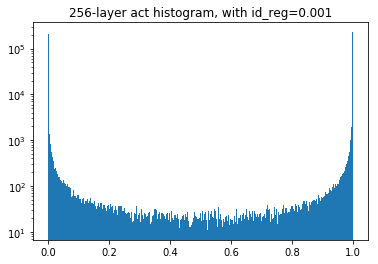

In [64]:
f, ax = plt.subplots(1,1)
plt.hist(no_idreg_act.flatten(),bins=1000)
ax.set_yscale('log')
ax.set_title('{}-layer act histogram, with id_reg={}'.format(no_idreg_act.shape[1], id_lam))
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/no_id_reg_hist.png')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


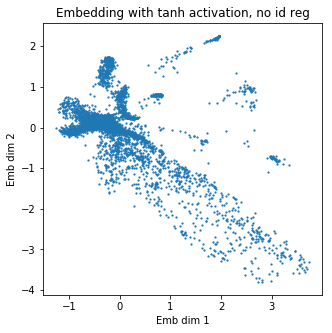

In [90]:
test_emb = sess.run(model.encoder, feed_dict={model.x_: data.data[:5000], model.is_training_: False})
f, ax = plt.subplots(figsize=(5,5))
plt.scatter(test_emb[:,0], test_emb[:,1], s=5, linewidths=0)
plt.title('Embedding with tanh activation, no id reg')
plt.xlabel('Emb dim 1')
plt.ylabel('Emb dim 2')
plt.show()
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/embedding-no-id.png')

In [99]:
decoded = sess.run(model.decoder, feed_dict={model.x_: data.data[:5000], model.is_training_: False})

In [92]:
data.__dict__.keys()

dict_keys(['_labeled', '_shuffle', '_data', '_test_data', '_min', '_max', '_mean_offset', '_genes', '_components', '_num_samples', '_index_in_epoch', '_epochs_trained', '_batch_number'])

In [100]:
y = data_inverse(data, decoded)

In [72]:
marker_genes = ['Stmn2', 'Tbr1', 'Olig1']



(5000, 27998)

In [101]:
num_steps = int(model.global_step_.eval() + steps_per_epoch * 10) # train for 10 epochs
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots, train_id=True)

Saving all run data to: ./saucie_models/mouse/17-10-12-runs/4
INFO:tensorflow:Total steps: 6300
INFO:tensorflow:TESTING -- epoch: 61, loss: 0.654701, recons_loss: 0.654621, id_loss: 8.07112E-05
INFO:tensorflow:Best model saved after 61 epochs
INFO:tensorflow:epoch 61, step 5439/6300: loss: 0.654918, recons_loss: 0.65484, id_loss: 7.82243E-05
INFO:tensorflow:epoch 61, step 5489/6300: loss: 0.654987, recons_loss: 0.65491, id_loss: 7.75333E-05
INFO:tensorflow:TESTING -- epoch: 62, loss: 0.654691, recons_loss: 0.654613, id_loss: 7.79310E-05
INFO:tensorflow:Best model saved after 62 epochs
INFO:tensorflow:epoch 62, step 5539/6300: loss: 0.654619, recons_loss: 0.654543, id_loss: 7.56268E-05
INFO:tensorflow:Saving model, after step 5550
INFO:tensorflow:TESTING -- epoch: 63, loss: 0.654631, recons_loss: 0.654555, id_loss: 7.61102E-05
INFO:tensorflow:Best model saved after 63 epochs
INFO:tensorflow:epoch 63, step 5589/6300: loss: 0.654878, recons_loss: 0.654802, id_loss: 7.57062E-05
INFO:tensor

OrderedDict([('loss', 0.65454638),
             ('recons_loss', 0.65447688),
             ('id_loss', 6.9478563e-05)])

In [56]:
acts_ = tf.get_collection('id_normalized_activations')
act = sess.run(acts_[0], feed_dict={model.x_: data.data[:5000], model.is_training_: False})
bin_act = utils.binarize(act)

Unique binary clusters: 4332
Cluster counts (greater than 1% of points), excluding 4999 points
-1.0,4999


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


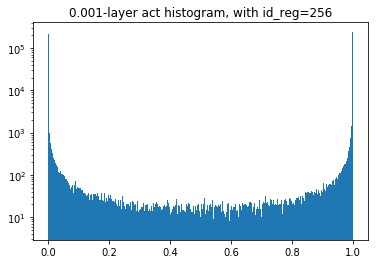

In [68]:
f, ax = plt.subplots(1,1)
plt.hist(act.flatten(),bins=1000)
ax.set_yscale('log')
ax.set_title('{}-layer act histogram, with id_reg={}'.format(id_lam, act.shape[1]))
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/id-hist.png')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


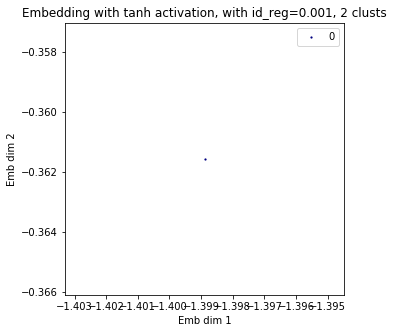

In [59]:
test_emb = sess.run(model.encoder, feed_dict={model.x_: data.data[:5000], model.is_training_: False})
f, ax = plt.subplots(figsize=(5,5))
clusters = np.unique(bin_act)
num_clusters = len(clusters)
if num_clusters < 40:
    colors = [plt.cm.jet(float(i) / num_clusters) for i in range(num_clusters)]
    for i in range(num_clusters-1):
        label = np.unique(bin_act)[i+1]
        subs = bin_act == label
        plt.scatter(test_emb[subs, 0], test_emb[subs, 1], s=5, linewidths=0, c=colors[i],
                    label=str(int(label)))
    plt.legend()
else:
    plt.scatter(test_emb[:,0], test_emb[:,1], s=5, linewidths=0)
plt.title('Embedding with tanh activation, with id_reg={}, {} clusts'.format(id_lam, num_clusters))
plt.xlabel('Emb dim 1')
plt.ylabel('Emb dim 2')
plt.show()
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/embedding.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


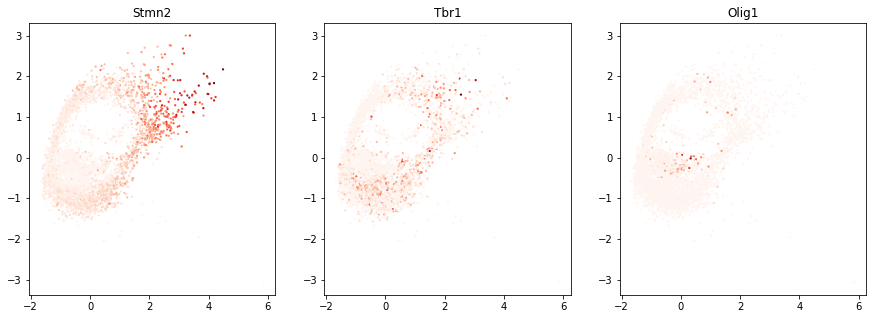

In [67]:
emb = sess.run(model.encoder, feed_dict={model.x_: data.data[:5000], model.is_training_: False})

# plot three markers: Stmn2 (pan-neuronal), Tbr1 (excitatory), Olig1 (oligodendrocytes)
marker_genes = ['Stmn2', 'Tbr1', 'Olig1']
f, axes = plt.subplots(1, len(marker_genes), figsize=(5*len(marker_genes), 5))

for gene, axis in zip(marker_genes, axes):
    expr = get_expression(gene_bc_matrix, gene)[:5000]
    axis.scatter(emb[:,0], emb[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()